## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

1.1.0


In [2]:
def poly(a,b,c,x):
    return a*(x-b)**2+c*tf.sin(x)

def poly_np(a,b,c,x):
    return a*(x-b)**2+c*np.sin(x)

def min_poly(a,b,c):
    return b, c

In [13]:
def gen_data_0(n_train, n_test):
    a_train = 0.5*np.ones((n_train,1))
    a_train[::3] = 0.2 
    b_train = 10.0*np.ones((n_train,1))
    b_train[0:n_train//2] = -10.0
    c_train = 20.0*np.ones((n_train,1))
    c_train[::2] = 0.0
    
    a_test = np.random.uniform(size=(n_test,1),low = 0.2, high = 2.0)
    b_test = np.random.uniform(size=(n_test,1),low = -10.0, high = 10.0)
    c_test = np.random.uniform(size=(n_test,1),low = 0.0, high = 20.00)
    
    return (a_train, b_train, c_train, a_test, b_test, c_test)

def gen_data_1(n_train, n_test):
    a_train = np.random.uniform(size=(n_train,1),low = 0.2, high = 2.0)
    b_train = (np.random.randint(size=(n_train,1), low = 0, high = 2)*2-1)*6
    c_train = np.random.uniform(size=(n_train,1),low = 10.0, high = 20.00)
    
    a_test = np.random.uniform(size=(n_test,1),low = 0.2, high = 2.0)
    b_test = (np.random.randint(size=(n_test,1), low = 0, high = 2)*2-1)*6
    c_test = np.random.uniform(size=(n_test,1),low = 10.0, high = 2.00)
    
    return (a_train, b_train, c_train, a_test, b_test, c_test)


def gen_data_with_pi(n_train, n_test):
    a_train = np.random.uniform(size=(n_train,1),low = 0.2, high = 2.0)
    b_train = np.random.randint(size=(n_train,1), low = -np.pi, high = np.pi)*2
    c_train = np.random.uniform(size=(n_train,1),low = 10.0, high = 20.00)
    
    a_test = np.random.uniform(size=(n_test,1),low = 0.2, high = 2.0)
    b_test = np.random.randint(size=(n_test,1), low = -np.pi, high = np.pi)*2
    c_test = np.random.uniform(size=(n_test,1),low = 10.0, high = 2.00)
    
    return (a_train, b_train, c_train, a_test, b_test, c_test)

In [14]:
# Number of Traing/Test examples
n_train = 160
n_test = 16

# Number of hidden states in RNN cell
n_hidden = 50

# Sequence length
num_steps = 20

# Generate Training Data
a_train, b_train, c_train, a_test, b_test, c_test = gen_data_with_pi(n_train, n_test)

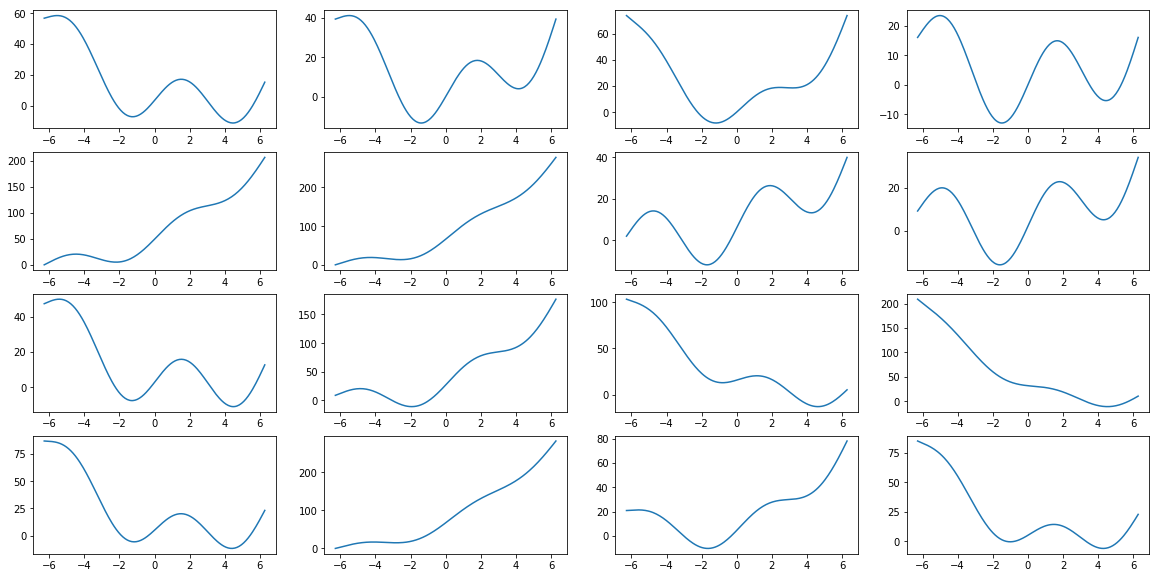

In [15]:
#NBCONVERTER_IGNORE
# visualize training data
plt.figure(figsize=(20,10))
for i in range(16):
    xx = np.linspace(-2*np.pi,2*np.pi,200)
    yy = poly_np(a_train[i], b_train[i], c_train[i],xx)
    # should we do 3D plot?
    plt.subplot(4,4,1+i)
    plt.plot(xx,yy)
plt.show()

In [32]:
# Create RNN Cell
# x, h = RNN(x, y, h)

variable_dict = {"W1": tf.Variable(tf.truncated_normal([1 + n_hidden, 100],stddev=0.01), name="W1"),\
                  "b1": tf.Variable(tf.zeros([100]), name="b1"),\
                  "W2": tf.Variable(tf.truncated_normal([100, n_hidden],stddev=0.01), name="W2"),\
                  "b2": tf.Variable(tf.zeros([n_hidden]), name="b2"),\
                  "Wx": tf.Variable(tf.truncated_normal([n_hidden, 1],stddev=0.01), name="Wx"),\
                  "bx": tf.Variable(tf.zeros([1]), name="bx")}

def rnn_cell(y, h, v_dict):
    h = tf.tanh(tf.matmul(tf.tanh(tf.matmul(tf.concat([y, h], 1),\
                                       v_dict["W1"]) + v_dict["b1"]), v_dict["W2"]) + v_dict["b2"])
    
    #dx = tf.split(z,[1, n_hidden],axis=1)
    dx = tf.matmul(h, v_dict["Wx"]) + v_dict["bx"]
        
    return (dx, h) 

In [33]:
# Create Model

size = tf.placeholder(tf.int32,[])

a = tf.placeholder(tf.float32, [None, 1])
b = tf.placeholder(tf.float32, [None, 1])
c = tf.placeholder(tf.float32, [None, 1])

x_0 = -0.0*tf.ones([size, 1])
h_0 = tf.ones([size, n_hidden])#tf.truncated_normal([size, n_hidden],stddev=0.1)

h = h_0
x = x_0
y = poly(a,b,c,x)
sample_points = [x]

f_min = y
f_sum = 0
for i in range(num_steps):
    
    dx, h = rnn_cell(y, h, variable_dict) # Q: why do we need /200?
    x += dx
    sample_points.append(x)
    y = poly(a,b,c,x)
    f_min = tf.minimum(y, f_min)
#     print(f_min)
    
    f_sum += tf.reduce_mean(y)

f_min = tf.reduce_mean(f_min)
loss = (f_sum) / num_steps

In [34]:
#print(sess.run([h], feed_dict={a: a_batch, b: b_batch, c: c_batch, size: batch_size}))

In [35]:
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
#train_step = tf.train.AdagradOptimizer(0.01).minimize(loss)
#train_step = tf.train.GradientDescentOptimizer(1.0).miFnimize(f_out)

In [36]:
#tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [37]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_loss_list = []
test_loss_list = []
train_fmin_list = []

In [38]:
# Train the Network
epochs = 3000
batch_size = 160

for ep in range(epochs):
    for batch in range(n_train//batch_size):
        a_batch = a_train[batch*batch_size:(batch+1)*batch_size]
        b_batch = b_train[batch*batch_size:(batch+1)*batch_size]
        c_batch = c_train[batch*batch_size:(batch+1)*batch_size]
        
        sess.run([train_step], feed_dict={a: a_batch, b: b_batch, c: c_batch, size: batch_size})
    
    train_loss_list += [sess.run([loss], feed_dict={a: a_train, b: b_train, c: c_train, size : n_train})]
    train_fmin_list += [sess.run([f_min], feed_dict={a: a_train, b: b_train, c: c_train, size : n_train})]
    test_loss_list  += [sess.run([loss], feed_dict={a: a_test, b: b_test, c: c_test, size:n_test})]
    
    if ep % 300 == 0 or ep == epochs-1:
        print("Epoch: " +str(ep)+" Training loss: "+str(train_loss_list[-1])\
              +"Minimum f value: "+ str(train_fmin_list[-1])+ " Test loss: "+str(test_loss_list[-1]))

Epoch: 0 Training loss: [12.329461]Minimum f value: [12.148845] Test loss: [13.092092]
Epoch: 300 Training loss: [-2.6644988]Minimum f value: [-5.0688319] Test loss: [12.685708]
Epoch: 600 Training loss: [-3.7507672]Minimum f value: [-4.6142535] Test loss: [10.526901]
Epoch: 900 Training loss: [-4.9416265]Minimum f value: [-5.2715158] Test loss: [8.2975368]
Epoch: 1200 Training loss: [-5.2295451]Minimum f value: [-6.0881109] Test loss: [5.7500744]
Epoch: 1500 Training loss: [-5.5826898]Minimum f value: [-6.8720589] Test loss: [4.690722]
Epoch: 1800 Training loss: [-5.9803634]Minimum f value: [-7.7953424] Test loss: [2.9163318]
Epoch: 2100 Training loss: [-6.3522677]Minimum f value: [-7.9399161] Test loss: [4.0735788]
Epoch: 2400 Training loss: [-6.6912413]Minimum f value: [-8.0721617] Test loss: [7.4771104]
Epoch: 2700 Training loss: [-6.8359809]Minimum f value: [-8.0917053] Test loss: [7.7886152]
Epoch: 2999 Training loss: [-6.9089684]Minimum f value: [-8.0999098] Test loss: [5.128088

In [39]:
# Extract Samples
samples_train = sess.run([sample_points], feed_dict={a: a_train, b: b_train, c: c_train, size: n_train})
samples_train = np.array(samples_train[0]).reshape(num_steps+1,n_train).T
samples_test = sess.run([sample_points], feed_dict={a: a_test, b: b_test, c: c_test, size: n_test})
samples_test = np.array(samples_test[0]).reshape(num_steps+1,n_test).T

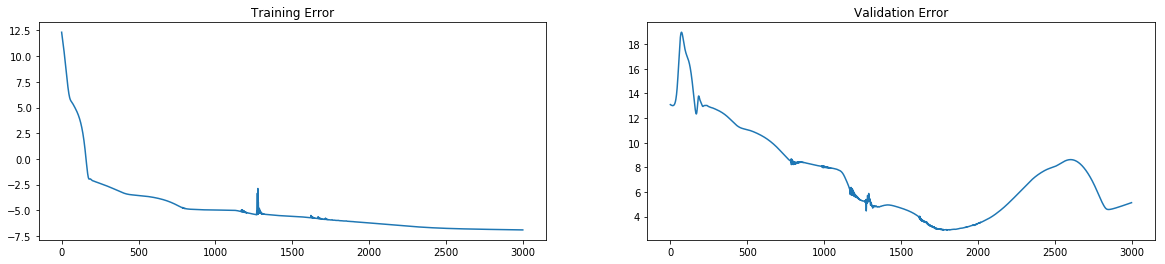

In [40]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(train_loss_list)
plt.title("Training Error")
plt.subplot(1,2,2)
plt.plot(test_loss_list)
plt.title("Validation Error")
plt.show()

In [41]:
def plot_result(traintest="train"): 
    if traintest == "train":
        a, b ,c = (a_train, b_train, c_train)
        samples = samples_train
        i = np.random.randint(n_train)
    else:
        a, b ,c = (a_test, b_test, c_test)
        samples = samples_test
        i = np.random.randint(n_test)
        
    annotation = list(range(num_steps+1))
    xx = np.linspace(-15,15,200)
    yy = poly_np(a[i],b[i],c[i],xx)

    samples_x = samples[i]
    samples_y = poly_np(a[i],b[i],c[i],samples_x)
    
    x_min, y_min = min_poly(a[i],b[i],c[i])

    j = i
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(xx,yy,linewidth=3)
    ax.scatter(samples_x,samples_y)
    #ax.scatter(x_min, y_min, marker='x', linewidth = 30)
    for i, txt in enumerate(annotation):
        if i == num_steps:
            ax.annotate(str(i), (samples_x[i],samples_y[i]),\
                xytext=(samples_x[i]+np.random.uniform(-1,1),\
                samples_y[i]+10.0), arrowprops=dict(facecolor='black', shrink=0.01))
    plt.show()
    print(samples_x)
    print( "y=%0.5f x=%0.5f" % ( np.min(samples_y),  samples_x[np.argmin(samples_y)] ) )
    print( "y=%0.5f x=%0.5f" % ( poly_np(a[j],b[j],c[j],x_min), x_min ) )
    print(x_min)
    
def plot_multiple(traintest="train",k=0):
    if traintest == "train":
        a, b ,c = (a_train, b_train, c_train)
        title_str = "Training Data"
        samples = samples_train
    else:
        a, b ,c = (a_test, b_test, c_test)
        title_str = "Test Data"
        samples = samples_test
      
    xx = np.linspace(-15,15,200)
    
    plt.figure(figsize=(20,10))
    for i in range(16):
        samples_x = samples[i]
        samples_y = poly_np(a[i],b[i],c[i],samples_x)
        yy = poly_np(a[i],b[i],c[i],xx)
        plt.subplot(4,4,i+1)
        plt.plot(xx,yy,linewidth=3)
        plt.scatter(samples_x,samples_y,color="k", alpha=0.2)
        plt.scatter(samples_x[-1], samples_y[-1], marker="*", s=100, c="y")
        #plt.title(str(["%.1f" % x for x in samples_x]))
        
    plt.suptitle(title_str)
    plt.show()

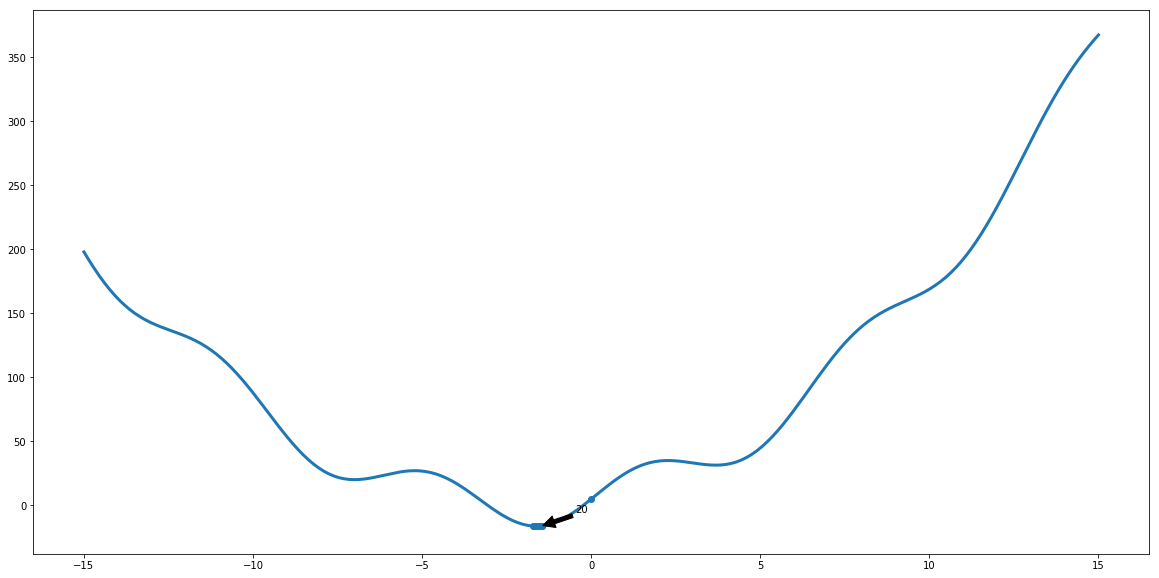

[-0.         -1.72010159 -1.68393898 -1.65650773 -1.65696657 -1.65818453
 -1.65377533 -1.64340067 -1.62903547 -1.61299276 -1.59688091 -1.58138394
 -1.56650984 -1.55195355 -1.53737319 -1.52252793 -1.5073061  -1.49169433
 -1.47573149 -1.45947123 -1.44296098]
y=-16.16554 x=-1.62904
y=-14.87892 x=-2.00000
[-2]


In [42]:
plot_result()

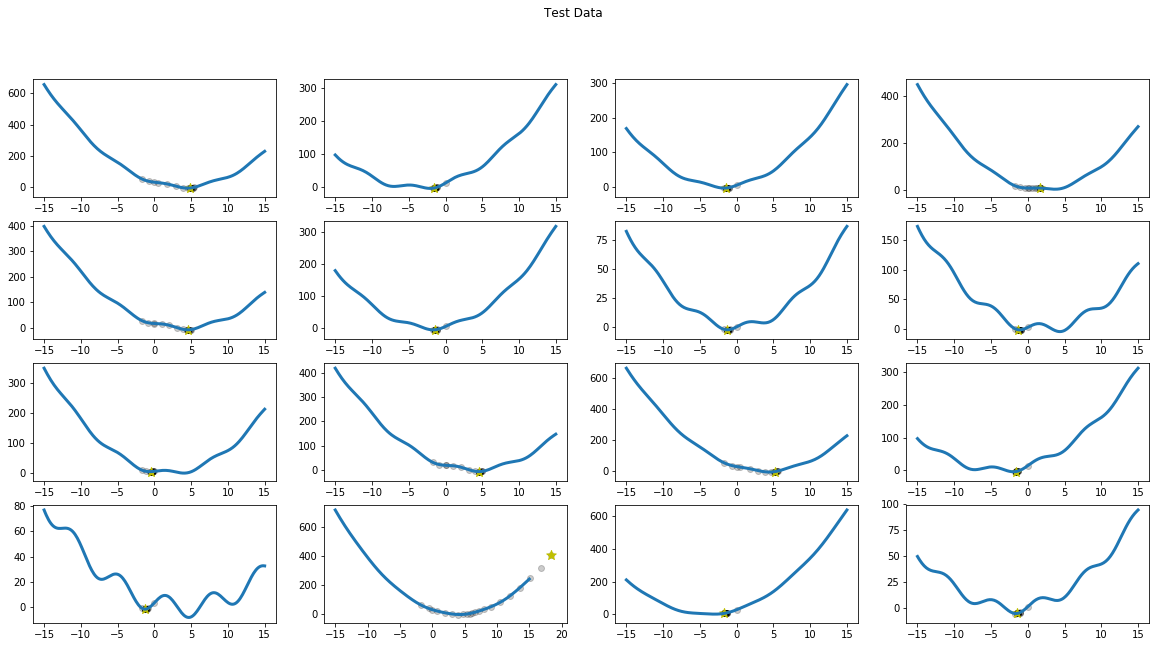

In [43]:
plot_multiple("test")

In [44]:
import scipy.optimize


In [45]:
x2 = np.linspace(-2*np.pi,2*np.pi,200)
a = a_train[0]
b = b_train[0]
c = c_train[0]
fc = lambda x: poly_np(a,b,c,x)

v_poly_np = np.vectorize(fc)

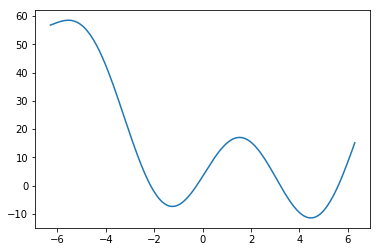

In [46]:
plt.plot(x2, v_poly_np(x2))
plt.show()

In [47]:
a_train[0]

array([ 0.82724307])

In [48]:
samples_test.shape

(16, 21)

In [55]:
a = 2
b = 3
c = 1
samples_x = np.linspace(-2*np.pi,2*np.pi,200)
samples_y = poly_np(a,b,c,samples_x)
print("min_poly:    y=%0.5f x=%0.5f" % ( poly_np(a,b,c,x_min), min_poly(a,b,c)[0] ) )
print("grid_search: y=%0.5f x=%0.5f" % ( np.min(samples_y),  samples_x[np.argmin(samples_y)] ) )


min_poly:    y=0.14112 x=3.00000
grid_search: y=0.01683 x=3.25210
